In [1]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import *
from qucat import Network,L,J,C,R
from modeling.qubits.clockmon.libraries.clockmon_library import clockmon_coupling_libraries, clockmon_library, clockmon_cqr_to_ground
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_library, digit_tee_ck_to_ground, get_ck
import scqubits as scq
from scqubits import ParameterSweep

In [2]:
smooth_capacitor_lib = digit_tee_library(deembed = [300, 200])
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])
clockmon_lib = clockmon_library(deembed = 200) 
cqr_to_ground = clockmon_cqr_to_ground(deembed = 200)

In [3]:
# Correction for next time...
# C = clockmon_lib(100)
# CR = C[0,1] + C[0,2] + C[0,0] - (C[0,1] + C[0,2])**2 / (C[0,1] + C[0,2] + C[1,1] + C[2,2])
# CR

In [4]:
# c_sigma - (cqr*1e-15)**2/ CR

In [5]:
# (cqr*1e-15)**2/ CR

In [6]:
planck_h = 6.62607015e-34
e_charge = 1.60217663e-19
phi0 =  2.067833848e-15 # Wb

a = 10e-6
b = 6e-6
ep_r = 11.45

nb_qubits = 4
rr_freq_target = np.array([7e9, 7.1e9, 7.2e9, 7.3e9])
qubit_freq_target = np.array([4e9, 4.1e9, 4.2e9, 4.3e9])
c_sigma = 90e-15
kappa_target = 0.8e6
target_parameters = {
    "chi": 0.4e6,
    "qubit_frequency": qubit_freq_target,
    "rr_frequencies_target": rr_freq_target,
    "c_sigma_unloaded": c_sigma
}
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real
l_r = Z0*pi/(4*pi*rr_freq_target)
c_r = 1/((2*pi*rr_freq_target)**2*l_r)

In [7]:
def minimize_func(x, c_r = None, l_r = None, target_qubit_frequency = None):
    cir = Network([
        C(0,1,c_sigma - x[0]*1e-15), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r - x[0]*1e-15), # resonator
        L(0,2,l_r),
        C(1,2, x[0]*1e-15), # coupling capacitor
    ])
    err_chi = abs(cir.kerr(Lj = x[1]*1e-9)[0,1] - 2*target_parameters["chi"])
    
    H = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = x[1]*1e-9)
    ee = H.eigenenergies().real
    ee -= ee[0]
    err_freq = abs(ee[1] - target_qubit_frequency)
    return err_chi, err_freq

In [8]:
cqrs = np.zeros((nb_qubits))
Ljs = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cqr, lj = fsolve(minimize_func, [4, 10], args =(c_r[i], l_r[i], qubit_freq_target[i]))
    cqrs[i] = cqr*1e-15
    Ljs[i] = lj*1e-9

print(cqrs)
print(Ljs)

[5.64611016e-15 5.52180111e-15 5.40211994e-15 5.28682069e-15]
[1.57395835e-08 1.50226866e-08 1.43535812e-08 1.37281202e-08]


In [9]:
Ic = get_Ic_from_Lj(Ljs)
EC = e_charge**2/(c_sigma)/2/planck_h
Ej = Ic*phi0/2/pi/planck_h

In [10]:
anharmonicities = np.zeros(4)
for i in range(4):
    transmon = Transmon(EJ = Ej[i], EC=EC, ng = 0, ncut = 31)
    anharmonicities[i] = transmon.anharmonicity()

Energy dispersion is  1.1519886196136474e-05 GHz


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$n_g$', ylabel='energy [GHz]'>)

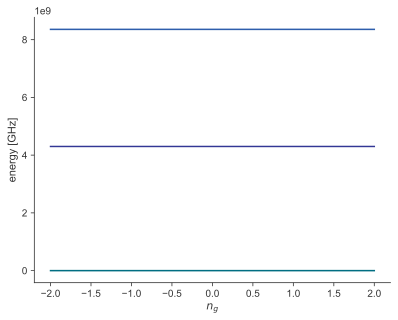

In [11]:
ng_list = np.linspace(-2, 2, 101)
e01_list = []
for ng in ng_list:
    e01_list.append(Transmon(EJ=Ej[0], EC=EC, ng=ng, ncut=31).E01())
e01_min = min(e01_list)
e01_max = max(e01_list)
delta_e01 = (e01_max - e01_min)/1e9
print("Energy dispersion is ", delta_e01, "GHz")
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=3, subtract_ground=True)

In [12]:
corrected_rr_freq = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cir = Network([
        C(0,1,c_sigma- cqrs[i]), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r[i] - cqrs[i]), # resonator
        L(0,2,l_r[i]),
        C(1,2, cqrs[i]), # coupling capacitor
        R(0, 2, 1e6)
        ])
    # f,k,A,chi = 
    cir.f_k_A_chi(pretty_print=True, Lj = Ljs[i])
    ham = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = Ljs[i])
    ee = ham.eigenenergies()
    ee -= ee[0]
    corrected_rr_freq[i] = ee[2]


         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.23 GHz |       229 Hz |      215 MHz |
            1 |     7.01 GHz |      560 kHz |       746 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      215 MHz |              |
            1 |      800 kHz |       746 Hz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.33 GHz |       239 Hz |      215 MHz |
            1 |     7.11 GHz |      568 kHz |       746 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      215 MHz |              |
            1 |      800 kHz |       746 Hz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.43 GHz |       249 Hz |      215 MHz |
            1 |     7.21 GHz |      576 kHz |       746 Hz |

Kerr coefficients (diagonal = Kerr, off-diag

 C:\Users\moret\AppData\Local\Temp\ipykernel_7332\664116265.py: 19

In [13]:
cir = Network([
    C(0,1,c_sigma- cqrs[i]), # transmon
    J(0,1,'Lj'),
    C(0,2,c_r[i] - cqrs[i]), # resonator
    L(0,2,l_r[i]),
    C(1,2, cqrs[i]), # coupling capacitor
    ])

In [14]:
g = 2*np.pi*EC/ (e_charge) * (Ej/EC/2)**(1/4) * cqrs / (c_r) * np.sqrt(2*planck_h * rr_freq_target * (c_r))
delta = (rr_freq_target - transmon.E01()) * 2*np.pi

lamb_shift = 2*g**2 / delta / 2 / np.pi
g/2/np.pi

array([96009807.89238504, 96353773.68167633, 96688132.68328464,
       97013281.43957366])

In [15]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi/ np.sqrt(2)
    return abs(k - kappa_target)

In [16]:
cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15
cks

array([1.00649953e-14, 9.85310507e-15, 9.64854646e-15, 9.45096918e-15])

In [17]:
# I think this is the right one. Check with eigenmode!
digit_cap_inductance = 1.6210000000000005e-11 # Simulate this
tee_cap_inductance = 3.1509999999999996e-11 # Simulate this
c_l, l_l = cpw_cl_ll(a, b, ep_r)
v_ph = 1/np.sqrt(c_l*l_l)
unloaded_wg_lengths = v_ph / rr_freq_target / 2
l_r_loaded = 1/2 * Z0 * np.sqrt((unloaded_wg_lengths*c_l - cqr_to_ground(cqrs) - ck_to_ground(cks))*
                                (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded = 2/(np.pi**2 * Z0)*np.sqrt((unloaded_wg_lengths*c_l - cqr_to_ground(cqrs) - ck_to_ground(cks))*
                                (unloaded_wg_lengths*l_l - digit_cap_inductance - tee_cap_inductance))
c_r_loaded -= cqrs
c_r_loaded -= cks
resonator_waveguide_lengths = np.pi * np.sqrt((c_r_loaded * l_r_loaded) / (c_l*l_l))
resonator_waveguide_lengths

array([0.00820197, 0.00808776, 0.00797669, 0.00786864])

In [18]:
coupler_width_given_c_qr, c_sigma_given_coupler_width = clockmon_coupling_libraries()
ck_given_coupling = get_ck()
for i in range(nb_qubits):
    coupler_width = coupler_width_given_c_qr(cqrs[i])
    finger_control = ck_given_coupling(cks[i])
    print(f"Coupler width for qubit {i}: {coupler_width:.5} um")
    print(f"Finger control for qubit {i}: {finger_control:.5}")
    print(f"Resonator length for qubit {i}: {resonator_waveguide_lengths[i]*1e6:.5} um")

Coupler width for qubit 0: 179.22 um
Finger control for qubit 0: 2.2653
Resonator length for qubit 0: 8202.0 um
Coupler width for qubit 1: 174.16 um
Finger control for qubit 1: 2.2482
Resonator length for qubit 1: 8087.8 um
Coupler width for qubit 2: 169.25 um
Finger control for qubit 2: 2.2312
Resonator length for qubit 2: 7976.7 um
Coupler width for qubit 3: 164.56 um
Finger control for qubit 3: 2.2142
Resonator length for qubit 3: 7868.6 um


In [19]:
fl_traits = pd.read_csv("single_clockmons_readout_structure00.csv").values[0][1:]
tee_size = pd.read_csv("single_clockmons_readout_structure00.csv").values[1][1:]
res_length = pd.read_csv("single_clockmons_readout_structure00.csv").values[2][1:]

tee_size = tee_size[pd.isna(tee_size) == 0]
res_length =res_length[pd.isna(res_length) == 0]

transmission_line_tee_points = []
transmission_line_tee_points += [float(fl_traits[0]) + (a+2*b)/2*1e6]
transmission_line_tee_points += [fl_traits[1] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[2] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[3] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[4] + (a+2*b)/2*1e6]

In [20]:
resonator_capacitance = c_r - cks -  cqrs

options = {
    "qubit_c": np.array([c_sigma]*4),
    "qubit_l": Ljs,
    "readout_resonator_c": resonator_capacitance,
    "readout_resonator_l": l_r,
    "ck": cks,
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "frequency": [7.3, 7.306],
    "n_points": 1001,
    "type": "simple",
    "a": a,
    "b": b,
    "ep_r": ep_r,
    "substrate_thickness": 550e-6
}

2-Port Network: '',  7.3-7.306 GHz, 1001 pts, z0=[50.+0.j 50.+0.j]


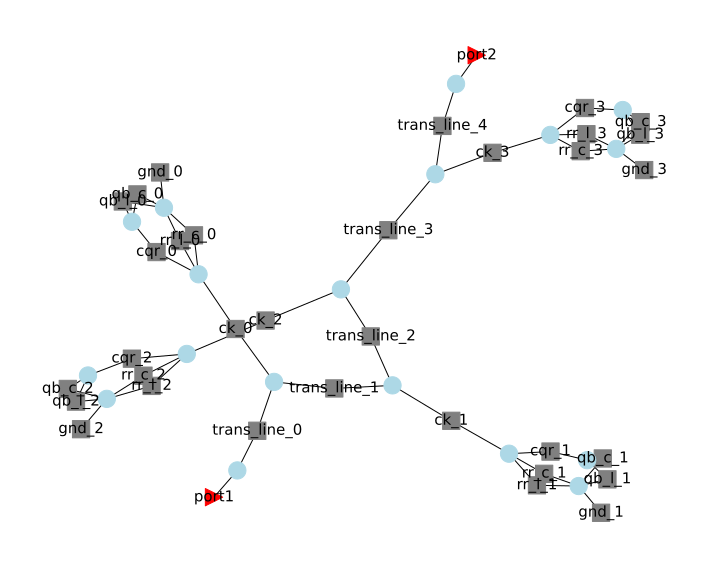

In [21]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

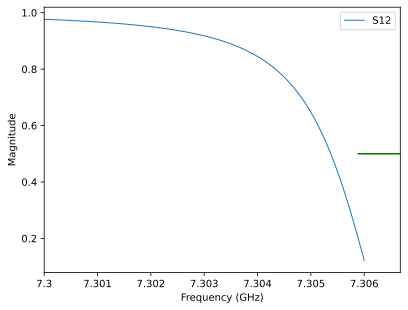

In [22]:
ntw.plot_s_mag(m=0, n=1, lw=1)
import matplotlib.pyplot as plt
# plt.vlines(x = 1/np.sqrt(c_r*l_r) / 2 / np.pi, ymin = 0, ymax = 1, colors="red")

# plt.vlines(x = 1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi +lamb_shift[-1], ymin = 0, ymax = 1, colors="red")
# plt.hlines(y = 0.5, xmin =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi - kappa_target/2 +lamb_shift[-1],
#            xmax =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi  + kappa_target/2 +lamb_shift[-1], colors="green")

plt.hlines(y = 0.5, xmin =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi - kappa_target/2 +lamb_shift[-1],
           xmax =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi  + kappa_target/2 +lamb_shift[-1], colors="green")

# # plt.vlines(x = 1/np.sqrt(c_r*l_r) / 2 / np.pi +lamb_shift, ymin = 0, ymax = 1, colors="red")
# plt.hlines(y = 0.5, xmin =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi - kappa_target/2 +lamb_shift[-1],
#            xmax =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi  + kappa_target/2 +lamb_shift[-1], colors="green")

In [23]:
cqr

5.286820692118826

Resonant frequency: 7306000001.476944 Hz
Q total: 2302.3860916662948
Q internal: -233466810316.64725
Complex phase: -0.30246162843557917


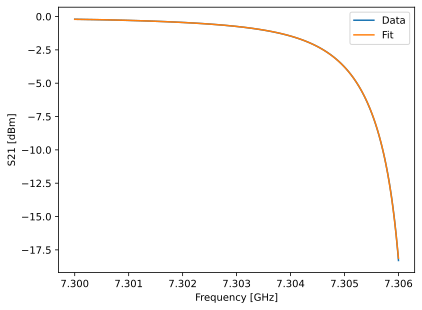

In [24]:
from modeling.resonance_fit import ResFit
# https://eprints.gla.ac.uk/323700/1/323700.pdf
initial_params = [1, 1e4, 1e7, 1, 1, 0, 0, 0]
fitter = ResFit(ntw, 0, 5000, ideal = False)
fitter.fit_resonance(initial_params=initial_params)
fitter.plot_resonance()

In [25]:
# T1 Purcell:
delta = rr_freq_target - target_parameters["qubit_frequency"]
k_purcell = kappa_target* (g/2/np.pi/delta)**2
T1_purcell = 1/(2*np.pi*k_purcell)
print(T1_purcell)

[0.00019424 0.00019286 0.00019153 0.00019024]


In [26]:
g_r_f = rr_freq_target**2*4*np.pi**2*Z0/2 * cks**2
c_r*2*np.pi*rr_freq_target/g_r_f

array([2507.5713611 , 2543.39380911, 2579.21625713, 2615.03870514])

In [27]:
# For when we'll need chargelines/fluxlines: https://quantumcomputing.stackexchange.com/questions/33136/how-to-estimate-the-losses-of-a-transmon-qubit-to-its-flux-bias-line

In [28]:
df = pd.DataFrame(columns=['resonator 01','qubit 01', 'anharmonicity','chi/2pi','g/2pi', 'C_sigma', 'Lj', 'Ic', 'T1 Purcell'], index=['qb0','qb1','qb2', 'qb3'])
df['resonator 01'] = rr_freq_target
df['qubit 01'] = qubit_freq_target
df['anharmonicity'] = anharmonicities
df['chi/2pi'] = [target_parameters["chi"]]*4
df['g/2pi'] = g/2/np.pi
df['C_sigma'] = [c_sigma]*4
df["Lj"] = Ljs
df['Ic'] = Ic
df['T1 Purcell'] = T1_purcell

In [29]:
df

,resonator 01,qubit 01,anharmonicity,chi/2pi,g/2pi,C_sigma,Lj,Ic,T1 Purcell
qb0,7.000000e+09,4.000000e+09,-2.481698e+08,400000.0,9.600981e+07,9.000000e-14,1.573958e-08,2.090945e-08,0.000194
qb1,7.100000e+09,4.100000e+09,-2.470907e+08,400000.0,9.635377e+07,9.000000e-14,1.502269e-08,2.190727e-08,0.000193
qb2,7.200000e+09,4.200000e+09,-2.460926e+08,400000.0,9.668813e+07,9.000000e-14,1.435358e-08,2.292849e-08,0.000192
qb3,7.300000e+09,4.300000e+09,-2.451643e+08,400000.0,9.701328e+07,9.000000e-14,1.372812e-08,2.397313e-08,0.000190


In [30]:
# Alternative to the minimization function that finds cqrs and Lj. Returns slightly different results for chi.
def minimize_func_alternative(x, c_r = None, l_r = None):
    EC = e_charge**2/(c_sigma)/2/planck_h
    Ic = get_Ic_from_Lj(x[1]*1e-9)
    Ej = Ic*phi0/2/pi/planck_h
    transmon = Transmon(EJ = Ej, EC=EC, ng = 0, ncut = 31)
    qubit = scq.GenericQubit(E=transmon.E01())
    resonator = scq.Oscillator(
        E_osc=1/np.sqrt(c_r*l_r) / 2 / np.pi,
        truncated_dim=8    # up to 3 photons (0,1,2,3)
    )
    hilbertspace = scq.HilbertSpace([qubit, resonator])
    bare_res_freq = 1/np.sqrt(c_r*l_r) / 2 / np.pi
    g = 2*np.pi*EC/ (e_charge) * (Ej/EC/2)**(1/4) * x[0]*1e-15 / (c_r) * np.sqrt(2*planck_h * bare_res_freq * (c_r))
    hilbertspace.add_interaction(
        g_strength = g/2/np.pi,
        op1 = qubit.sm_operator,
        op2 = resonator.creation_operator,
        add_hc = True,
        id_str="qubit-resonator"  # optional keyword argument
    )
    pname = 'ng'
    ng_vals = np.linspace(-0.5, 0.5, 1)
    paramvals_by_name = {pname: ng_vals}
    sweep = ParameterSweep(
        hilbertspace=hilbertspace,
        paramvals_by_name=paramvals_by_name,
        update_hilbertspace=lambda v: None,
        evals_count=10,
        subsys_update_info={},
    )
    chi = sweep["chi"]["subsys1":0, "subsys2":1][0, 1]/2
    

    err_chi = abs(chi - target_parameters["chi"])
    ee = hilbertspace.eigenvals()
    ee -= ee[0]
    
    chi = (g**2) * (1 / (ee[1] - ee[2]) + 1 / (ee[1] + ee[2]))

    err_freq = abs(ee[1] - target_parameters["qubit_frequency"])
    return err_chi, err_freq